In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar   
N = norm.cdf
import pandas as pd
import time

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/codearmo/data/master/calls_calib_example.csv')

print(df.head(10))

   Strike  Moneyness     Bid  Midpoint     Ask        F     T
0   900.0       0.76  2856.1   2867.55  2879.0  3803.79  0.74
1  1000.0       0.74  2757.0   2768.45  2779.9  3803.79  0.74
2  1100.0       0.71  2658.0   2669.45  2680.9  3803.79  0.74
3  1200.0       0.68  2559.1   2570.55  2582.0  3803.79  0.74
4  1300.0       0.66  2460.3   2471.75  2483.2  3803.79  0.74
5  1400.0       0.63  2361.6   2373.05  2384.5  3803.79  0.74
6  1500.0       0.61  2263.0   2274.45  2285.9  3803.79  0.74
7  1550.0       0.59  2213.8   2225.25  2236.7  3803.79  0.74
8  1600.0       0.58  2164.7   2176.15  2187.6  3803.79  0.74
9  1650.0       0.57  2115.6   2126.20  2136.8  3803.79  0.74


In [20]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p 


def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p 

In [21]:
def optimal_params(x, mkt_prices, strikes):
    candidate_prices = merton_jump_call(S, strikes, T, r,
                                        sigma=x[0], m= x[1] ,
                                        v=x[2],lam= x[3])
    return np.linalg.norm(mkt_prices - candidate_prices, 2)


T = df['T'].values[0]
S = df.F.values[0]
r = 0 
x0 = [0.15, 1, 0.1, 1] # initial guess for algorithm
bounds = ((0.01, np.inf) , (0.01, 2), (1e-5, np.inf) , (0, 5)) #bounds as described above
strikes = df.Strike.values
prices = df.Midpoint.values

res = minimize(optimal_params, method='SLSQP',  x0=x0, args=(prices, strikes),
                  bounds = bounds, tol=1e-20, 
                  options={"maxiter":1000})
sigt = res.x[0]
mt = res.x[1]
vt = res.x[2]
lamt = res.x[3]

print('Calibrated Volatlity = ', sigt)
print('Calibrated Jump Mean = ', mt)
print('Calibrated Jump Std = ', vt)
print('Calibrated intensity = ', lamt)

/Users/philipgadereumert/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Calibrated Volatlity =  0.06489484923349984
Calibrated Jump Mean =  0.8789049529375553
Calibrated Jump Std =  0.15420408492821921
Calibrated intensity =  0.9722941920510377


In [31]:
S

1000

Text(0.5, 1.0, 'Merton Model Optimal Params')

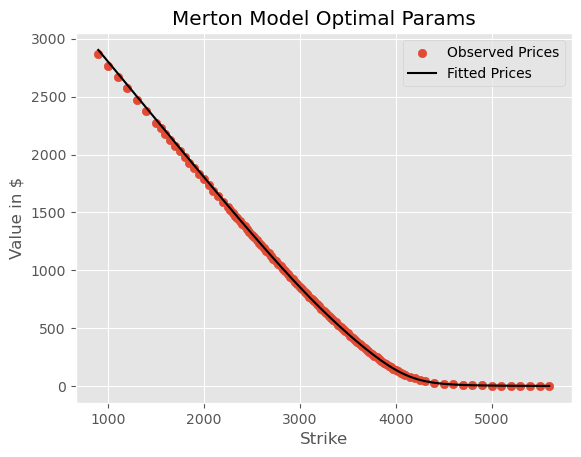

In [22]:
df['least_sq_V'] = merton_jump_call(S, df.Strike, df['T'], 0 ,sigt, mt, vt, lamt)

plt.scatter(df.Strike, df.Midpoint,label= 'Observed Prices')
plt.plot(df.Strike, df.least_sq_V, color='black',label= 'Fitted Prices')
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Value in $')
plt.title('Merton Model Optimal Params')

In [23]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S

In [53]:
def merton_jump_to_ruin_paths(S, T, r, sigma, lam, steps, Npaths):
    size = (steps, Npaths)
    dt = T/steps
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((r - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S
    stock_paths[ruin_indices] = 0  # Set to zero after the jump

    return stock_paths

In [58]:
S = 100 # current stock price
T = 1 # time to maturity
r = 0.02 # risk free rate
m = 0 # meean of jump size
v = vt # standard deviation of jump
lam = lamt # intensity of jump i.e. number of jumps per annum
steps = 250 # time steps
Npaths = 10 # number of paths to simulate
sigma = sigt # annaul standard deviation , for weiner process

Calibrated Volatlity =  0.06489484923349984

Calibrated Jump Mean =  0.8789049529375553

Calibrated Jump Std =  0.15420408492821921

Calibrated intensity =  0.9722941920510377

Text(0.5, 1.0, 'Jump Diffusion Process')

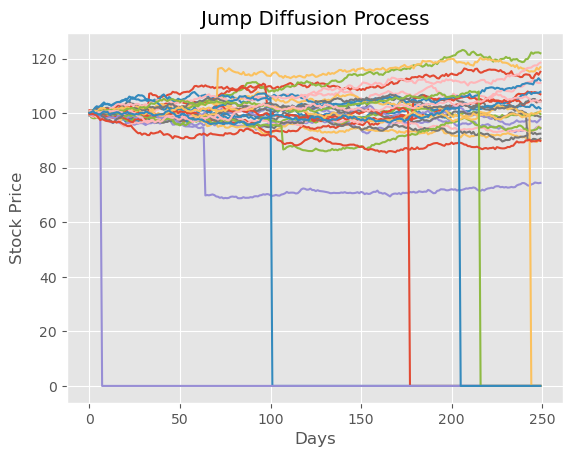

In [59]:
j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)
GBM = merton_jump_paths(S, T, r, sigma, 0, 0, 0, steps, Npaths)
JR = merton_jump_to_ruin_paths(S, T, r, sigma, lam, steps, Npaths)

plt.plot(GBM)
plt.plot(j)
plt.plot(JR)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')